<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/HiringBias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Colab](https://img.shields.io/badge/Google-Colab-F9AB00?style=plain&logo=googlecolab&color=525252)
[![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=plain&logo=scikit-learn&logoColor=white)](https://scikit-learn.org/stable/)
[![Matplotlib](https://img.shields.io/badge/Matplotlib-%23ffffff.svg?style=plain&logo=Matplotlib&logoColor=black)](https://matplotlib.org/)
[![Code style: black](https://img.shields.io/badge/code%20style-black-000000.svg)](https://github.com/psf/black)

# Hiring Bias

Is gender bias in hiring easy to judge? This study, on synthetic data, demonstrates that such questions require carefull statistical modelling.

## Data

Read two data sources: admissions and candidate tables, and merge them.

In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()
!unzip -d data hiring_datasets.zip

df_admisions = pd.read_csv("/content/data/admissions.csv")
df_candidates = pd.read_csv("/content/data/candidates.csv")

# NOTE: remove duplicates and check 1:1 match on the tables
df_candidates.set_index("candidate_id", inplace=True)
assert df_candidates.index.is_unique
df_admisions.drop_duplicates(inplace=True)
df_admisions.set_index("candidate_id", inplace=True)
assert df_admisions.index.is_unique

df = df_candidates.join(df_admisions)
assert len(df_candidates) == len(df_admisions)
df.head()
print(df.shape)

## Exploratory Analysis

The data coverage looks good: the missing data is mostly card id (about 2/3 missing) which is hopefully not valuable. 

The plots illustrate the impact of predictors (age, gender, family size, department) on the admission status. Some quick findings are:
* older candidates are more likely to get hired
* females are rejected more often compared to males - we will see that this alone is not enough to claim discrimination (!)
* competetitive departments - such as F - seem to overly reject, when compared to others (Data Science roles? :D)
* applicants without children are rarely accepted

NOTE: The data summarization statistics revealed one record with anomalous age (removed).


In [ ]:
df.isna().mean()

name           0.000000
age            0.000000
gender         0.000000
no_children    0.147572
emp_card_id    0.650062
department     0.000000
admit          0.000000
dtype: float64

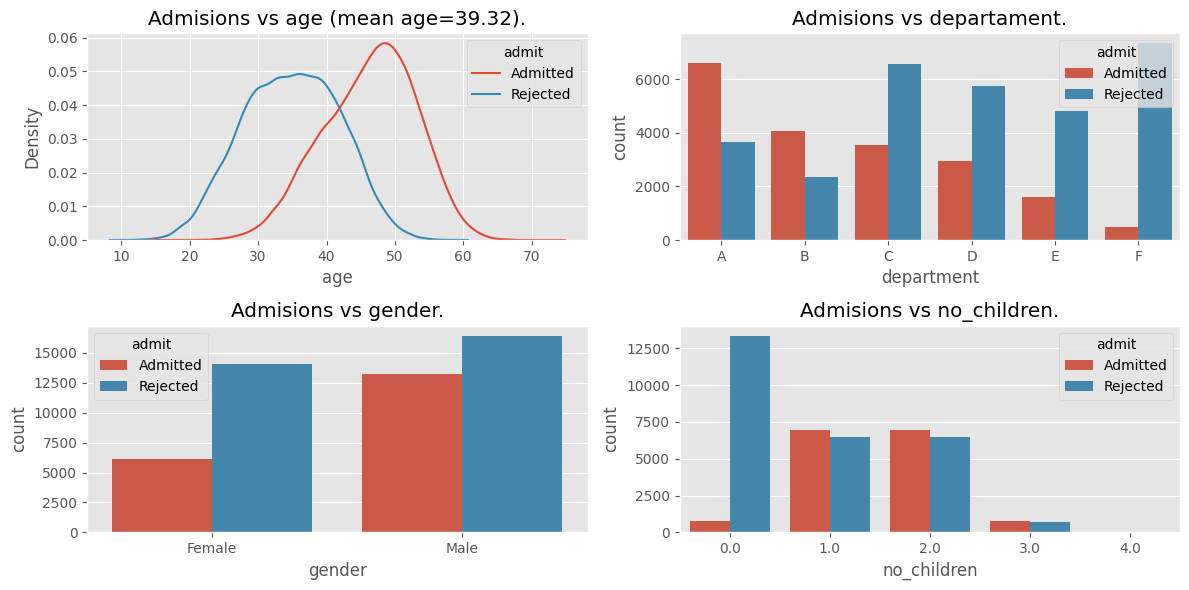

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
hue_order = ["Admitted", "Rejected"]

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs = axs.ravel()

# analyze age impact on hiring
ax = axs[0]
df = df[df["age"] <= 100]
sns.kdeplot(
    data=df,
    x="age",
    hue="admit",
    common_norm=False,
    clip=(0, 100),
    ax=ax,
    hue_order=hue_order,
)
ax.set_title(f'Admisions vs age (mean age={df["age"].mean().round(2)}).')

# analyze deparment impact on hiring
ax = axs[1]
df_department_agg = df.groupby("department").value_counts(["admit"])
df_department_agg.name = "count"
sns.barplot(
    data=df_department_agg.reset_index(),
    y="count",
    x="department",
    hue="admit",
    ax=ax,
    hue_order=hue_order,
)
ax.set_title(f"Admisions vs departament.")

# analyze gender impact on hiring
ax = axs[2]
df_sex_agg = df.groupby("gender").value_counts(["admit"])
df_sex_agg.name = "count"
sns.barplot(
    data=df_sex_agg.reset_index(),
    y="count",
    x="gender",
    hue="admit",
    ax=ax,
    hue_order=hue_order,
)
ax.set_title(f"Admisions vs gender.")

# analyze family impact on hiring
ax = axs[3]
df_family_agg = df.groupby("no_children").value_counts(["admit"])
df_family_agg.name = "count"
sns.barplot(
    data=df_family_agg.reset_index(),
    y="count",
    x="no_children",
    hue="admit",
    ax=ax,
    hue_order=hue_order,
)
ax.set_title(f"Admisions vs no_children.")


plt.tight_layout()
plt.show()

In [ ]:
df_family_agg

no_children  admit   
0.0          Rejected    13355
             Admitted      761
1.0          Admitted     6959
             Rejected     6483
2.0          Admitted     6969
             Rejected     6473
3.0          Admitted      747
             Rejected      679
4.0          Admitted        8
             Rejected        4
Name: count, dtype: int64

# Predictive Modelling

We will build a simple predicitve model of reasonable accuracy, and use it to quantitatively confirm the findings from the exploratory analysis.

## Model

The model uses `sklearn.pipeline` to combine an imputer, feature scaler and a one-layer linear classifier to predict "admitted" outcome.

Categorical features such as the number of children and department id are one-hot encoded in `pandas`. 

In [ ]:
X_enc = pd.concat(
    [
        df[["age"]],
        pd.get_dummies(df["no_children"], prefix="kids", drop_first=False),
        pd.get_dummies(df["gender"], prefix="sex", drop_first=True),
        pd.get_dummies(df["department"], prefix="department", drop_first=False),
    ],
    axis=1,
)
y_enc = df["admit"] == "Admitted"

X = X_enc.to_numpy().astype("float32")
y = y_enc.to_numpy().ravel().astype("float32")

X_enc.head()

,age,kids_0.0,kids_1.0,kids_2.0,kids_3.0,kids_4.0,sex_Male,department_A,department_B,department_C,department_D,department_E,department_F
candidate_id,,,,,,,,,,,,,
928100,43.0,0,0,0,0,0,0,0,0,0,1,0,0
913797,51.0,1,0,0,0,0,1,0,0,1,0,0,0
926775,30.0,0,0,1,0,0,1,0,0,0,1,0,0
919847,31.0,1,0,0,0,0,0,0,0,1,0,0,0
936127,24.0,1,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
df.isna().mean()

name           0.000000
age            0.000000
gender         0.000000
no_children    0.147575
emp_card_id    0.650075
department     0.000000
admit          0.000000
dtype: float64

In [ ]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier


model = Pipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression()),
    ]
)

baseline_model = Pipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("classifier", DummyClassifier(strategy="most_frequent")),
    ]
)

## Validation

Since the problem is not unbalanced, it makes sense to look at the good old accuracy. Furthermore, we will evaluate the ROC curve of this binary classificaiton. For both methodological robustness and coding brevity, we will use cross-validation provided by the `sklearn` API. Note that with recent releases of `sklearn` it is convenient to use `RocCurveDisplay` to quickly visualize ROC curves.

The model is quite good and significantly outperforms the "most frequent guess" baseline.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

rocauc_scorer = make_scorer(roc_auc_score)

cv = StratifiedKFold(n_splits=10, shuffle=True)
scores = cross_val_score(model, X, y, cv=cv)
benchmark_scores = cross_val_score(baseline_model, X, y, cv=cv)
print("Model accuracy: {:.3f}±{:.3f}".format(scores.mean(), scores.std()))
print(
    "Majority-guess (baseline) accuracy: {:.3f}±{:.3f}".format(
        benchmark_scores.mean(), benchmark_scores.std()
    )
)
rocauc_scores = cross_val_score(model, X, y, cv=cv, scoring=rocauc_scorer)
print("Model ROC-AUC: {:.3f}±{:.3f}".format(rocauc_scores.mean(), rocauc_scores.std()))

Model accuracy: 0.897±0.003
Majority-guess (baseline) accuracy: 0.612±0.000
Model ROC-AUC: 0.893±0.005


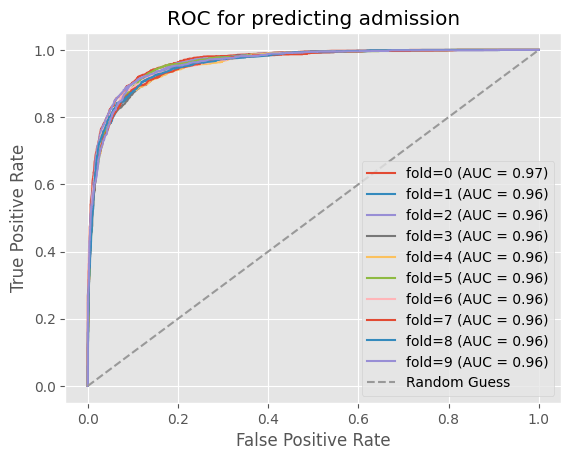

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


ax = plt.gca()
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    model.fit(X[train_idx], y[train_idx]).predict_proba(X[test_idx])
    display = RocCurveDisplay.from_estimator(
        model, X[test_idx], y[test_idx], ax=ax, pos_label=1, name=f"fold={i}"
    )

plt.plot([0, 1], [0, 1], "--", color=(0.6, 0.6, 0.6), label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for predicting admission")
plt.legend(loc="lower right")
plt.show()

## Interpretation / Statistical Insights

Cherry on the pie: we will look into statistical insights. 

Firstly, we will plot model weights as proxies for feature importances. Secondly, we will apply bootstrapping to confirm significance statistically. 

**Concusion**: *Age has the strongest positive impact* on the hiring decision, followed by *having children*, and *department competetiveness* is important too. 
When accounting for age and children we see no  evidence for discrimination towards females anymore. Males in this dataset have much different work-family profiles than females: they tend to have higher age and have more family obligations (both thought as proxies for experience and loyalty) and apply for less competetive roles (cf. departments A vs C).

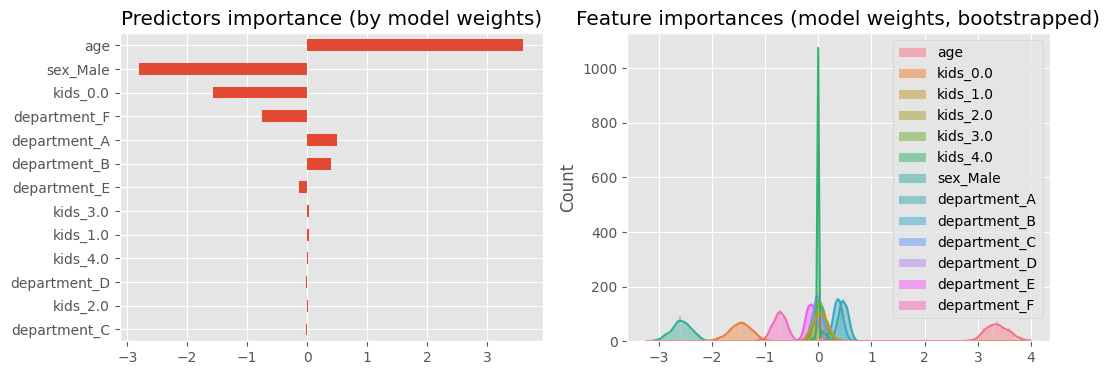

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# compute and visualize feature importances

ax = axs[0]
model.fit(X, y)
importances = pd.Series(
    dict(zip(X_enc.columns, *model.named_steps["classifier"].coef_))
)
importances = importances.sort_values(key=lambda x: abs(x), ascending=True)
fig = importances.plot(kind="barh", ax=ax)
ax.set_title("Predictors importance (by model weights)")

# bootstrap and visualize distributon of importances

from sklearn.utils.random import sample_without_replacement

N_BOOTSTRAPS = 1000

model_coefs = []

for _ in range(N_BOOTSTRAPS):
    train_idx = sample_without_replacement(len(X), 1000)
    model.fit(X[train_idx], y[train_idx])
    model_coefs.append(model.named_steps["classifier"].coef_.ravel())

model_coefs = np.array(model_coefs)

ax = axs[1]
importances = pd.DataFrame(model_coefs, columns=X_enc.columns)
sns.histplot(data=importances, common_norm=False, kde=True, ax=ax)
ax.set_title("Feature importances (model weights, bootstrapped)")

plt.show()

In [ ]:
# differences in males / females

pd.concat(
    [
        df.groupby("gender").agg(
            {
                "age": "mean",
                "no_children": "mean",
            }
        ),
        df.groupby("gender")["department"].value_counts(normalize=True).unstack(),
    ],
    axis=1,
)

,age,no_children,A,B,C,D,E,F
gender,,,,,,,,
Female,32.529205,0.480501,0.058856,0.013624,0.323161,0.204360,0.214169,0.185831
Male,43.945777,1.501136,0.306554,0.208108,0.120777,0.154966,0.070980,0.138615


In [ ]:
from google.colab import drive

drive.mount("/content/drive")
!pip install black[jupyter] --quiet
!black /content/drive/MyDrive/'Colab Notebooks'/'HiringBias.ipynb'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All done! ✨ 🍰 ✨
1 file left unchanged.


# More

In terms of model improvements, feature selection did not make sense on data of that small-dimension. One can always engineer more features or bring an even more powerful model. Perhaps insights can be easier delivered and nicer demonstrated with explainable techniques, such as Shapley values. However, while building the model is easy, optimization is much harder and time-consuming. This notebook aims to demonstrate quick and robust fiindings, particularly matching conclusions of exploratory analysis and statistical inference.